week5_mini_project_

In [1]:
# Packages
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Tensorflow config
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
# Check if GPU is used
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

The code below sets the model training strategy according to the processor type, and outputs the processor details. Kaggle's GPU T4 X2 and TPU VM v3-8 were not compatible with TensorFlow due to incompatibilities with CUDA version 12.2 and possibly with cuDNN. Using Kaggle's GPU P100 returned warning messages that hinted at compatibility problems, but the model compiled and trained without issue.

[Ref](https://www.kaggle.com/code/stevenhobbs74/hobbs-monet-cyclegan#INTRODUCTION-&-SETUP)

In [ ]:
# Kaggle notebook setting
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu) # Connects to the given cluster
    tf.tpu.experimental.initialize_tpu_system(tpu) # Initializes the TPU system
    strategy = tf.distribute.TPUStrategy(tpu) # TPU distribution strategy
    print('Running on TPUs')

except ValueError:
    print("TPU not available.")
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print("Running on GPU.")
    else:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU.")

print('Number of accelerators (CPU, GPU, or TPU):', strategy.num_replicas_in_sync)
print("Tensorflow Version:", tf.__version__)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime.')
else:
    print('Using a high-RAM runtime!')

## I. Brief Introduction

* Goal:

    The primary goal of this project is to train a GAN, which consists of at least two neural networks: a generator and a discriminator model, and <u>__the generator model should generate images in the style of Monet__</u>. To meet the goal, I will try two architectures with different design and hyperparameter settings, which is a big highlight in this project. 

*  Data and project description
    
    1. We have __300 Monet paintings for training and 7,028 photos for style transformation__, all sized 256x256 in both JPEG and TFRecord format.

    2. There are different types of GANs, and we will mainly use <u>__CycleGAN__</u> in this project. __CycleGAN is a model that aims to solve the image-to-image translation problem__, and its goal is to learn the mapping between an input image and an output image using a training set of aligned image pairs. However, obtaining paired examples isn't always feasible, and that's also the reason why we only have 300 Monet paintings but having 7,028 photos. CycleGAN tries to learn this mapping without requiring paired input-output images, using cycle-consistent adversarial networks. 
    
        In this implementation, generators are trained to create realistic Monet paintings from training images and vice versa. Meanwhile, discriminators learn to differentiate between real Monet paintings and photos from the generated ones. Through this competitive training process, the generators continuously improve their ability to produce realistic artwork, while the discriminators become adept at identifying the fakes.

    3. <u>__TFRecord__</u> is Tensorflow’s own binary record format. [This article](https://towardsdatascience.com/building-a-cyclegan-model-with-custom-dataset-using-tensorflow-2-12d66be16378) has great explanation of what TFRecord is and I quote a small part from it - 
    
        There are a few advantages of using TFRecord format:

        * It is a binary format, therefore takes less space in disk and less read/write time in memory.
        
        * With TFRecord, we can combine multiple datasets into one dataset. For example — in this work, we combine multiple images into one TFRecord. This combined record is well integrated into the data loading and preprocessing functionalities of `tf.data.Datasets`. This is specially helpful when loading a really big dataset — instead of loading the entire dataset in the memory, the dataset library can load only the necessary portion of the TFRecord for processing.

## II. EDA

### (1) Load and data preprocessing

* In this section, we will use the Tensorflow `TFRecord` files, and load/parse the data with `tf.data.Dataset`. On the other hand, the data input pipeline execute the following works,

    * parsing the data involves conveting the serialized tfrecords into Tensorflow dictionaries,
    
    * decoding the Tensorflow string into a 3D tensor, 
    
    * setting the data type to `float32`, 
    
    * scaling the data to [-1, 1], 
    
    * and reshaping the data to 256 x 256.

In [4]:
image_path = Path.home() /"Desktop/gan-getting-started"
MONET_FILENAMES = tf.io.gfile.glob(str(image_path.as_posix() + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(image_path.as_posix() + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [46]:
# Data preprocessing
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # Scale the images to [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    # Decode the TFRecord
    tfrecord_format = {
        "image_name" : tf.io.FixedLenFeature([], tf.string),
        "image" : tf.io.FixedLenFeature([], tf.string),
        "target" : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Extract the image from files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [38]:
# Load images
monet_dataset = load_dataset(MONET_FILENAMES, labeled=True).batch(1).shuffle(1024)
photo_dataset = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1).shuffle(1024)
monet_dataset = monet_dataset.prefetch(AUTOTUNE)
photo_dataset = photo_dataset.prefetch(AUTOTUNE)

In [39]:
# Example images
example_monet = next(iter(monet_dataset))
example_photo = next(iter(photo_dataset))

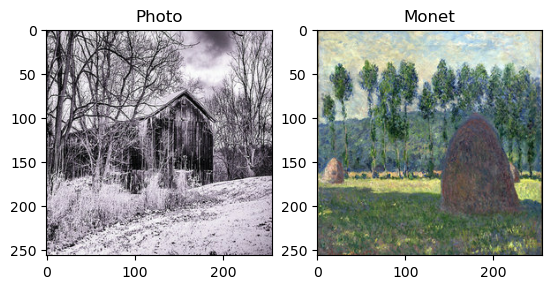

In [40]:
# Data preview
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### (2) Data augmentation

* For a special task like transferring the style of one image to another, data augmentation needs to be done carefully. If you change the colors too much (like brightness, contrast, or saturation), the machine might get confused about the original style it's supposed to learn from. So, in this case, it's better to just flip, rotate, or crop the images instead of drastically changing their colors. This way, the machine can focus on learning the core style from the original data. On the other hand, I also add some randomness to create variety and prevent overfitting.

In [ ]:
# Data augmentation for the images
def data_augmentation(image):
    # Use random choices for augmentations to create variety and prevent overfitting.
    spatial_r = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    rotate_r = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # 90 degrees rotations
    if rotate_r > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif rotate_r > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif rotate_r > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if spatial_r > .75:
        image = tf.image.transpose(image)
            
    # Focusing on a 128x128 pixel area. This helps the model learn from different details each time, even within the same image.
    image = tf.image.random_crop(image, size=[128, 128, 3])
        
    return image

## III. Structure Design

* What is U-Net?
    Our structure of CycleGAN leverages a <u>__U-Net__</u> architecture ([U-Net paper for biomedical image segmentation](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/)). Before we dive into the structure, let's first see what a U-Net architecture is.

    U-Net is a powerful Convolutional Neural Network (CNN) architecture designed for image segmentation, and it has two special powers to tackle the challenge.

    **Superpower 1: Capturing Details (Contracting Path):**

    Just like a detective gathers clues, U-Net starts by analyzing the image in detail. It uses a series of convolutional layers, which act like tiny magnifying glasses, to zoom in and capture important features like shapes, edges, and textures. This initial part of U-Net is called the contracting path. As it goes deeper, the image shrinks but essential details are preserved. 
    The author opted for instance normalization (`tfa.layers.InstanceNormalization`) instead of the more common batch normalization (`tf.keras.layers.BatchNormalization`). As TensorFlow now doesn't natively support instance normalization, we'll utilize group normalization (`tensorflow.keras.layers.GroupNormalization`), and set `groups = -1` to have the same effect as `InstanceNormalization`. For more information about the GroupNormalization, please refer to the [document](https://keras.io/api/layers/normalization_layers/group_normalization/).

    **Superpower 2: Locating Precise Areas (Expanding Path):**

    Now that we have a good understanding of the image's details, it's time to pinpoint specific areas. U-Net's second superpower comes into play here - the expanding path. It uses special techniques to increase the resolution of the information it has and combines it with the detailed features extracted earlier. Think of it like a map with precise locations highlighted on top of a detailed drawing. This allows U-Net to accurately identify and segment specific regions of interest in the image.

    **The Competition Makes Perfect:**

    During training, U-Net is constantly challenged. It's shown real images with segmented areas and has to predict those segmentations itself. If it's wrong, it gets gently nudged in the right direction. This competition between U-Net and the training data helps it become a segmentation expert.

    **Overall, U-Net's combination of detailed feature extraction and precise localization makes it a valuable tool for image segmentation tasks.**


* Implementated structure

    To construct __the unet-style generator__, we'll first establish functions for downsampling and upsampling the input images. This technique is demonstrated in [Tensorflow CycleGAN Tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan) as well as [this CycleGAN tutorial by Amy Jang](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook#Introduction-and-Setup). __Both of the tutorials are fairly informative__ and some of my codes are modified based on theirs.

    `Downsampling` (for capturing details), as the term implies, reduces the image's two-dimensional size (width and height) by a factor determined by the `stride`. The stride specifies how far the filter moves between applications. Since the stride is set to 2, the filter is applied to every other pixel, effectively halving both the width and height. `Upsampling` does the opposite of downsample and increases the dimensions of the image. 

    The two tutorials opted for instance normalization from Tensorflow Addons (`tfa.layers.InstanceNormalization`) instead of the more common batch normalization (`tf.keras.layers.BatchNormalization`). As Tensorflow now doesn't natively support instance normalization, we'll utilize group normalization (`tensorflow.keras.layers.GroupNormalization`), and set `groups = -1 or groups = the number of the input channels` to have the same effect as `InstanceNormalization`. For more information about the GroupNormalization, please refer to the [Keras V2 document](https://keras.io/2.16/api/layers/normalization_layers/group_normalization/) and [Keras V3 document](https://keras.io/api/layers/normalization_layers/group_normalization/).

    The `downsample` and `upsample` funtions combine standard layers (`Conv2D/Conv2DTranspose, GroupNormalization, Dropout, and LeakyReLu/Relu`) into blocks, which are shorter and easier to work with, and still allow specification of filter number and kernel size.

    *NOTE:  
    I am using Windows system, and in order to use GPU, I had to install Tensorflow v2.10.0, whose Keras version doesn't support `tf.keras.layers.BatchNormalization`. Thus, I use `tfa.layers.GroupNormalization` as an alternative, but if running the code on Kaggle notebook, `keras.layers.GroupNormalization` is supported.

In [26]:
OUTPUT_CHANNELS = 3

def downsample(filters, kernel_size=4, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(
        filters, kernel_size, 
        strides=2, 
        padding='same',
        kernel_initializer=initializer, 
        use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))
        # result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
        # result.add(keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result


def upsample(filters, kernel_size=4, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(
        filters, kernel_size, 
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False))

    result.add(tfa.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))
    # result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    # result.add(keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### (1) Build generator

The generator involves a combination of different layers as well as skip connection:

* **Convolutional layers (downsample) or transpose convolutional layers (upsample):** These extract or inject features from the image, like identifying edges or adding details.

* **Group normalization:** This helps the network learn more effectively.

* **Dropout layer:** This randomly drops some information during training to prevent overfitting, which makes the model more adaptable to different situations.

* **Activation function (`ReLU` or `LeakyReLU`):** This adds non-linearity to the process, allowing the network to learn complex patterns.

The final layer uses a different activation function (`tanh`) to output the generated image with values between __-1 and 1__.

**Shortcut Connections (Skip Connections):**

Skip connections are like helpful notes that remind you of important details from earlier steps. They directly connect information from earlier stages in the generator to later stages. This helps the model remember crucial details about the original image and prevents information from getting lost as it goes through many steps. These connections are shown as curved arrows in the diagram after the function definitions.


In [27]:
# Build the generator
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Model structure
    down_stack = [
        downsample(64, apply_instancenorm=False), # (bs, 128, 128, 64), bs = batch size
        downsample(128), # (bs, 64, 64, 128)
        downsample(256), # (bs, 32, 32, 256)
        downsample(512), # (bs, 16, 16, 512)
        downsample(512), # (bs, 8, 8, 512)
        downsample(512), # (bs, 4, 4, 512)
        downsample(512), # (bs, 2, 2, 512)
        downsample(512), # (bs, 1, 1, 512)
    ]

    # The output of each upsample layer is double the number of filters, because the skip connections 
    # concatenate the output of the downsample layer to a corresponding upsample layer.

    up_stack = [
        upsample(512, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512), # (bs, 16, 16, 1024)
        upsample(256), # (bs, 32, 32, 512)
        upsample(128), # (bs, 64, 64, 256)
        upsample(64), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### (2) Build discriminator

The discriminator involves three main layers:

* **Downsampling Layers:**  
    Using three `downsample` blocks, which progressively extract higher-level features from the image, going from low-level details (edges, colors) to more abstract features in deeper layers.

* **Bottleneck Layers:**

    * Zero Padding layer:  
        This adds padding to the feature maps from the previous downsample layer (`down3`). Padding ensures the output size remains the same after the convolution operation.
        
    * Convolutional layer
        
    * Group Normalization
        
    * LeakyReLU

    **This bottleneck layer (conv + norm + activation) is the core part of the Discriminator. It extracts high-level features and helps differentiate between real and fake images.**

* **Output Layer:**

    * Zero Padding layer

    * Convolutional layer

    __The discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.__


In [28]:
# Build the discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, apply_instancenorm=False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    
    conv = layers.Conv2D(
        512, 4, 
        strides=1,
        kernel_initializer=initializer,
        use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    # norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    norm1 = tfa.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

### Structure 2

In [ ]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=layers.ReLU(), name='block_x'):
    block = layers.Conv2D(filters, size, 
        strides=strides, 
        padding='same', 
        use_bias=False, 
        kernel_initializer=conv_initializer, 
        name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
        kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
     # block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = layers.ReLU()(block)
    
    block = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
        kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
     # block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    
    block = layers.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = layers.Conv2DTranspose(filters, size, 
        strides=strides, 
        padding='same', 
        use_bias=False, 
        kernel_initializer=conv_initializer, 
        name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = layers.ReLU()(block)
    
    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    
#     block = tf.pad(block, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC") # Works only with GPU
#     block = layers.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False, # Works only with GPU
    block = layers.Conv2D(filters, size, 
        strides=strides, 
        padding='same', 
        use_bias=False, 
        kernel_initializer=conv_initializer, 
        name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = layers.ReLU()(block)
    
    return block

In [ ]:
def Generator():

    inputs = layers.Input(shape=[256, 256, 3], name='input_image')
    OUTPUT_CHANNELS = 3

    # Encoder - 3 blocks
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=layers.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=layers.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=layers.ReLU(), name='block_3')   # (bs, 64, 64, 256)
    
    # Transformer - 6 blocks
    x = enc_3
    transformer_blocks = 6
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder - 3 blocks
    x_skip = layers.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    
    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = layers.Conv2D(OUTPUT_CHANNELS, 7, 
        strides=1, padding='same', 
        kernel_initializer=conv_initializer, 
        use_bias=False, 
        activation='tanh', 
        name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = keras.Model(inputs, outputs)
    
    return generator

In [ ]:
def Discriminator():
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')

    # Encoder - 4 blocks
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=layers.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)
    
    discriminator = keras.Model(inputs, outputs)
    
    return discriminator


sample_discriminator = Discriminator()
sample_discriminator.summary()

### (3) Architecture diagram & model summary

In [41]:
# strategy = tf.distribute.get_strategy()
# APPLY DISTRIBUTION STRATEGY TO MODELS
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

c:\Users\ordin\miniconda3\envs\ml\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


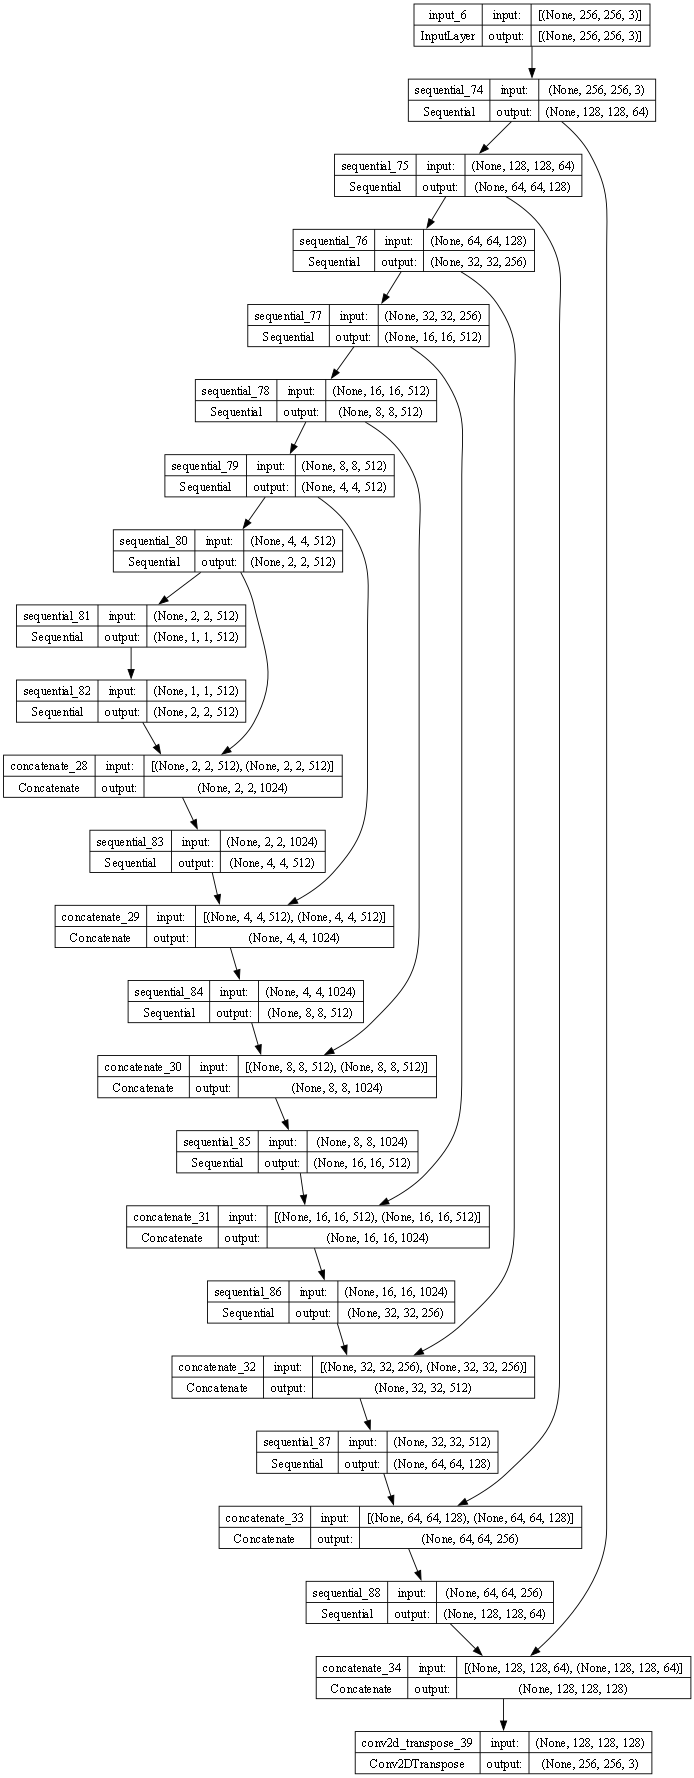

In [42]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [43]:
print("Monet Generator Model Summary:", monet_generator.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_38 (Sequential)     (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_39 (Sequential)     (None, 64, 64, 128)  131328      ['sequential_38[0][0]']          
                                                                                            

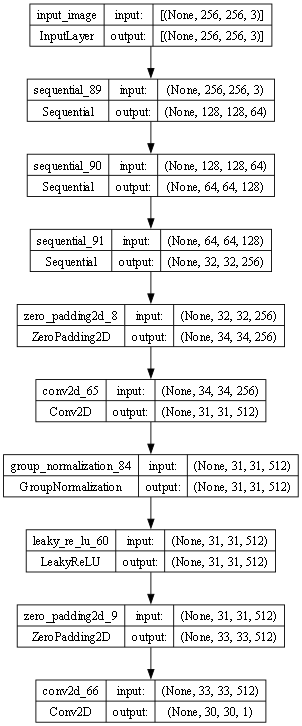

In [44]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [45]:
print("Monet Discriminator Model Summary:", monet_discriminator.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_68 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_69 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_70 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 34, 34, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### (4) Build CycleGAN model

The CycleGAN subclasses a `tf.keras.Model` so that we can run fit() later to train our model for translating images between two Monet paintings and photos. Here's a simplified breakdown:

* **The Players:**

    * Two Generators (`m_gen` and `p_gen`): Translate Monet images to photos and vice versa.

    * Two Discriminators (`m_disc` and `p_disc`): Distinguish real Monets/photos from generated ones.

* **The Training Dance:**

    1. **Generator Train:** Generate fake images (Monet from photos and photo from Monets).

    2. **Cycle Consistency:** Ensure the cycled images (photo->fake Monet->photo or Monet->fake photo->Monet) resemble the originals.

    3. **Identity Loss:** Penalize generators for significantly changing real images during translation (want them to preserve some identity).

    4. **Discriminator Train:** Discriminator tries to catch the fakes, while generators try to fool it.

* **The Loop:**

    * The code iterates through training data (real Monets and photos).

    * For each iteration, it calculates losses for generators and discriminators based on the strategies above. (Loss functions will be defined in the next section)

    * Gradients are calculated and applied to update the weights of generators and discriminators, making them better at their tasks over time.

In [30]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        # Call the compile() of the parent class (keras.Model), initializing the base properties and methods
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:

            ## Generating part
            # Generating a cycled photo: photo --> fake Monet --> photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Generating a cycled Monet: Monet --> fake photo --> Monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating same Monet and same photo
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            ## Discriminating part
            # Discriminating real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminating fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            ## Evaluate losses
            # Generator loss on fake images
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### (5) Loss functions

* `strategy.scope()` tells Tensorflow to distribute the model's operations according to the strategy defined in the "Kaggle notebook setting" after the packages import section.

* The purpose of each loss function has been illustrated in the last section.

In [31]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [32]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [33]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [34]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## IV. Modeling

In [35]:
# Define optimizer
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
# Instantiate the model
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [37]:
# Training
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=1
)

300/300 [==============================] - 99s 226ms/step - monet_gen_loss: 5.3182 - photo_gen_loss: 5.4285 - monet_disc_loss: 0.6116 - photo_disc_loss: 0.6196


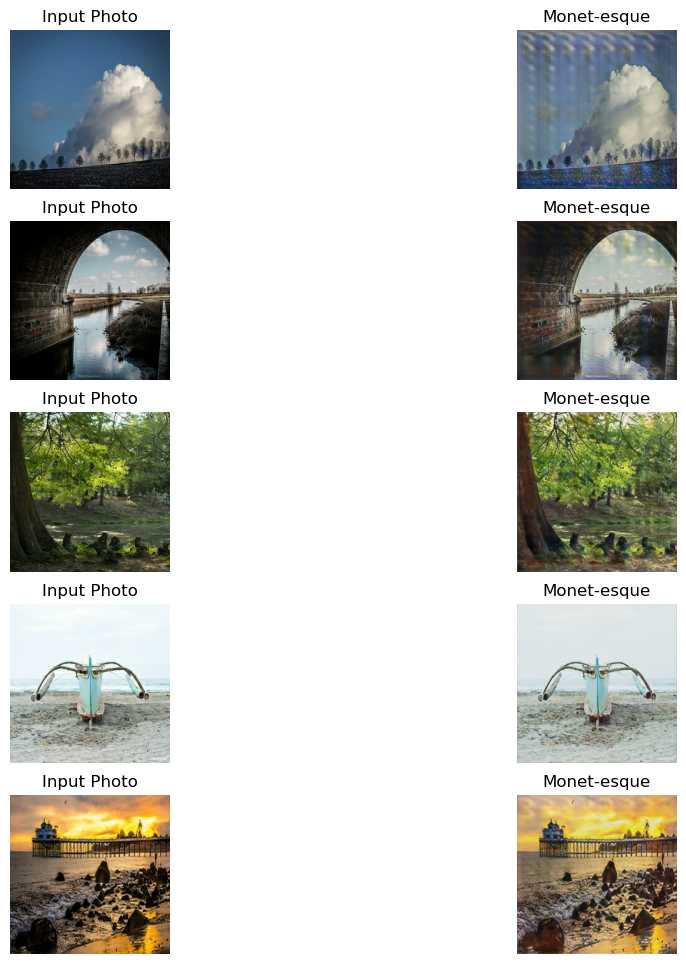

In [24]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


## Second Model

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

In [5]:
input_dim = (256, 256, 3) #input/output image dimension
depth = 4               #network depth  
kernel = 3              #kernel size for Conv2D
n_batch = 16            #batch_size
epochs = 30
steps = round(1500/n_batch) #steps per epoch, we have ~1500 samples per domain so calculating steps using 

In [1]:
import os, random, json, PIL, shutil, re #glob, imageio
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
# from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback
import tensorflow_addons as tfa


# def seed_everything(seed=0):
#     random.seed(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
# SEED = 0
# seed_everything(SEED)

c:\Users\ordin\miniconda3\envs\ml\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\ordin\miniconda3\envs\ml\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

### Load images

In [2]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 120
TRANSFORMER_BLOCKS = 6
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

In [ ]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=AUTO)
    dataset = dataset.map(normalize_img, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    
    return dataset

def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        f = plt.figure(figsize=(12, 12))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()
    
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)
        
        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')
        
        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')
        
        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')
        
    plt.show()

def create_gif(images_path, gif_path):
    images = []
    filenames = glob.glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),  # Coordinates
                                 f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [26]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    
#     # Random jitter
#     image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
#     # Crops
#     if p_crop > .6: # random crop
#         crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
#         image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
#     elif p_crop > .2: # central crop
#         if p_crop > .5:
#             image = tf.image.central_crop(image, central_fraction=.7)
#         elif p_crop > .35:
#             image = tf.image.central_crop(image, central_fraction=.8)
#         else:
#             image = tf.image.central_crop(image, central_fraction=.9)
            
    # Train on crops
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])
        
    
    return image

In [3]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = L.ReLU()(block)
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    
    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    
#     block = tf.pad(block, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC") # Works only with GPU
#     block = L.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False, # Works only with GPU
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

### Discriminator

In [4]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder    
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=L.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)
    
    discriminator = Model(inputs, outputs)
    
    return discriminator


sample_discriminator = discriminator_fn()
sample_discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 encoder_block_1 (Conv2D)    (None, 128, 128, 64)      3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 encoder_block_2 (Conv2D)    (None, 64, 64, 128)       131072    
                                                                 
 instance_normalization (Ins  (None, 64, 64, 128)      256       
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                             

c:\Users\ordin\miniconda3\envs\ml\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


### Generator

In [5]:
def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=L.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_3')   # (bs, 64, 64, 256)
    
    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = L.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    
    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = L.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = Model(inputs, outputs)
    
    return generator

sample_generator = generator_fn()
sample_generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_block_1 (Conv2D)       (None, 256, 256, 64  9408        ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 re_lu_1 (ReLU)                 (None, 256, 256, 64  0           ['encoder_block_1[0][0]']        
                                )                                                           

In [12]:
strategy = tf.distribute.get_strategy()

with strategy.scope():
    monet_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
    photo_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn(height=None, width=None) # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_photo_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': photo_disc_loss
               }

In [13]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

120 total epochs and 439 steps per epoch
Learning rate schedule: 0.0002 to 0.0002 to 5.7e-07


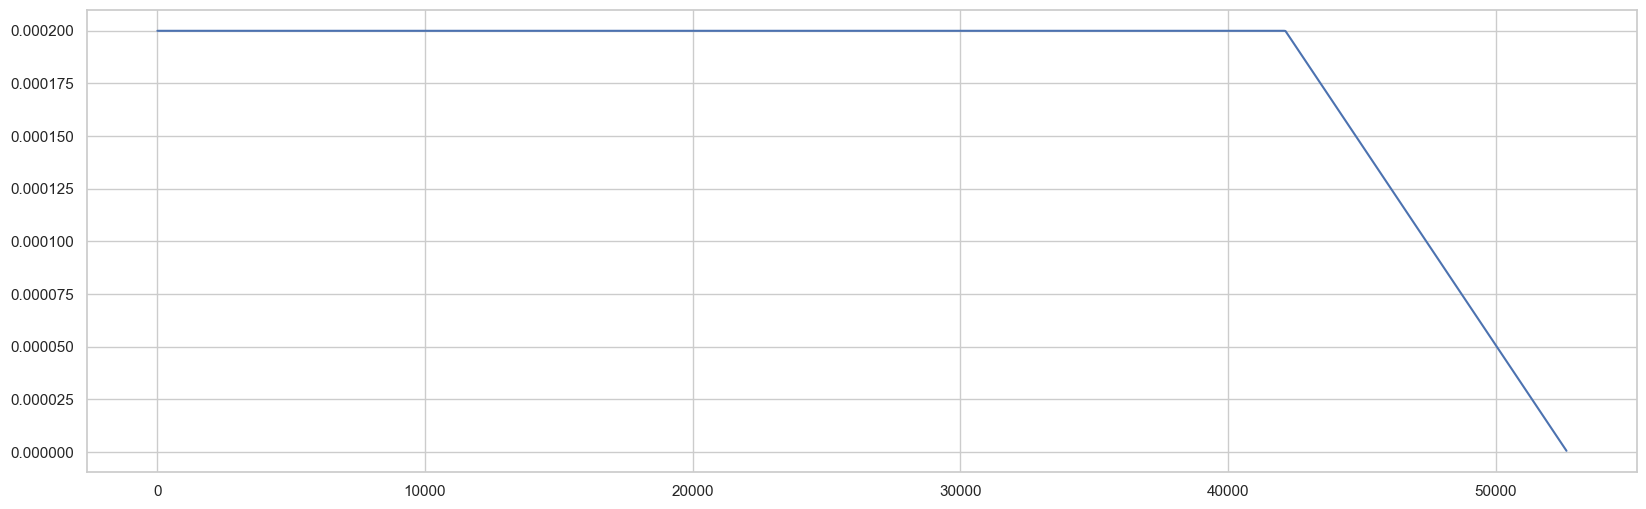

In [15]:
n_monet_samples=300
n_photo_samples=7038

@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [16]:
with strategy.scope():
    # Create generators
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    # Create discriminators
    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)

    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)

In [21]:
AUTO = tf.data.experimental.AUTOTUNE
MONET_FILENAMES = tf.io.gfile.glob(str(image_path.as_posix() + '/monet_tfrec/monet*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(image_path.as_posix() + '/photo_tfrec/photo*.tfrec'))
photo_ds_eval = get_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)
monet_ds_eval = get_dataset(MONET_FILENAMES, repeat=False, shuffle=False, batch_size=1)

In [22]:
# Callbacks
class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=1, monet_path='monet', photo_path='photo'):
        self.num_img = num_img
        self.monet_path = monet_path
        self.photo_path = photo_path
        # Create directories to save the generate images
        if not os.path.exists(self.monet_path):
            os.makedirs(self.monet_path)
        if not os.path.exists(self.photo_path):
            os.makedirs(self.photo_path)

    def on_epoch_end(self, epoch, logs=None):
        # Monet generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            # prediction.save(f'{self.monet_path}/generated_{i}_{epoch+1}.png')
            
        # Photo generated images
        for i, img in enumerate(monet_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generated_{i}_{epoch+1}.png')

### Training

In [27]:
# Create dataset
monet_ds = get_dataset(MONET_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

In [28]:
history = gan_model.fit(gan_ds, 
                        epochs=EPOCHS, 
                        # callbacks=[GANMonitor()], 
                        steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE), 
                        verbose=2).history

Epoch 1/120
439/439 - 1145s - monet_gen_loss: 2.5715 - photo_gen_loss: 3.1631 - monet_disc_loss: 0.6045 - photo_disc_loss: 0.5920 - 1145s/epoch - 3s/step
Epoch 2/120
439/439 - 766s - monet_gen_loss: 2.2538 - photo_gen_loss: 2.3153 - monet_disc_loss: 0.6042 - photo_disc_loss: 0.5849 - 766s/epoch - 2s/step
Epoch 3/120
439/439 - 518s - monet_gen_loss: 2.2024 - photo_gen_loss: 2.5039 - monet_disc_loss: 0.5494 - photo_disc_loss: 0.5766 - 518s/epoch - 1s/step
Epoch 4/120
439/439 - 528s - monet_gen_loss: 2.3193 - photo_gen_loss: 2.6536 - monet_disc_loss: 0.6033 - photo_disc_loss: 0.5199 - 528s/epoch - 1s/step
Epoch 5/120
439/439 - 552s - monet_gen_loss: 2.2793 - photo_gen_loss: 2.2662 - monet_disc_loss: 0.6417 - photo_disc_loss: 0.6731 - 552s/epoch - 1s/step
Epoch 6/120
439/439 - 552s - monet_gen_loss: 2.3792 - photo_gen_loss: 2.3766 - monet_disc_loss: 0.6800 - photo_disc_loss: 0.6412 - 552s/epoch - 1s/step
Epoch 7/120


KeyboardInterrupt: 

In [19]:

# def discriminator(input_dim, depth, kernel):
#     layers = []
#     layers.append(keras.Input(shape=input_dim))
#     for i in range(1, depth):
#             layers.append(layers.Conv2D(16*i,kernel_size=kernel))
#             layers.append(layers.InstanceNormalization())
#             layers.append(layers.Activation('relu'))
#             layers.append(layers.Dropout(0.2))
#     layers.append(layers.Conv2D(1,kernel_size=kernel))
#     model = keras.Sequential(layers)
#     model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
#     return model


def discriminator(input_dim, depth, kernel):

    encoder_inputs = keras.Input(shape=input_dim)

    x = layers.Conv2D(filters = 16, kernel_size=3, use_bias=False, strides=2, padding='same',)(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(32, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Conv2D(1, kernel_size=3)(x) 

    model = keras.Model(encoder_inputs, output, name='discriminator')
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
    print(model.summary())
    return model

# Declare 2 discriminators for each domain classification
discriminator_A = discriminator(input_dim, depth, kernel)
discriminator_B = discriminator(input_dim, depth, kernel)


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_70 (Conv2D)          (None, 128, 128, 16)      432       
                                                                 
 batch_normalization_73 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 activation_72 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 dropout_72 (Dropout)        (None, 128, 128, 16)      0         
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 32)        4608      
                                                     

In [21]:
def generator(input_dim, depth, kernel):

    inputs = keras.Input(shape=input_dim)

    x = layers.Conv2D(filters = 16, kernel_size=3, use_bias=False, strides=2, padding='same',)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(32, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2DTranspose(filters = 16, kernel_size=3, use_bias=False, strides=2, padding='same',)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2DTranspose(32, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2DTranspose(128, kernel_size=3, use_bias=False, strides=2, padding='same',)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Conv2DTranspose(3, kernel_size=1, activation=None, strides=2, padding='same',)(x) 

    model = keras.Model(inputs, output, name='generator')
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
    print(model.summary())
    return model

generator_A_B = generator(input_dim,depth,kernel)
generator_B_A = generator(input_dim,depth,kernel)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_88 (Conv2D)          (None, 128, 128, 16)      432       
                                                                 
 batch_normalization_97 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 activation_96 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 dropout_96 (Dropout)        (None, 128, 128, 16)      0         
                                                                 
 conv2d_89 (Conv2D)          (None, 64, 64, 32)        4608      
                                                         

In [ ]:
# Get the cyclic connection in
def composite_model(g1,d,g2,image_dim):
    # Only the 1st generator is trainable
    g1.trainable = True
    g2.trainable = False
    d.trainable = False
    
    # Adversarial loss 
    input_img = Input(shape=input_dim)
    g1_out = g1(input_img)
    d_out = d(g1_out)
    
    # identity loss
    input_id = Input(shape=input_dim)
    g1_out_id = g1(input_id)
    
    # Cycle Loss, Forward cycle
    g2_out = g2(g1_out)
    
    # Cycle Loss, Backward-cycle
    g2_out_id = g2(input_id)
    output_g1 = g1(g2_out_id)
    
    # Model is compiled with:
    # Inputs: Input_A(Summer), Input_B(winter)
    # Outputs: d_out, g1_out_id, g2_out, output_g1
    model = Model(inputs=[input_img, input_id], outputs=[d_out, g1_out_id, g2_out, output_g1])
    model.compile(loss=['mse','mae','mae','mae'], loss_weights=[1,5,10,10], optimizer=tf.keras.optimizers.Adam())
    return model

composite_A_B = composite_model(generator_A_B, discriminator_B, generator_B_A, input_dim)
composite_B_A = composite_model(generator_B_A, discriminator_A, generator_A_B, input_dim)

In [ ]:
# Generating samples & labels for training
def generate_real(dataset, batch_size, patch_size):
    labels = np.ones((batch_size, patch_size, patch_size, 1))
    return dataset,labels
def generate_fake(dataset, g, batch_size, patch_size):
    predicted = g(dataset)
    labels = np.zeros((batch_size, patch_size, patch_size, 1))
    return predicted,labels

In [ ]:
checkpoint_dir = './cyclegan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_A_B=generator_A_B, generator_B_A=generator_B_A,discriminator_A=discriminator_A,discriminator_B=discriminator_B,composite_A_B=composite_A_B, composite_B_A=composite_B_A)
manager = tf.train.CheckpointManager(checkpoint, 'training_checkpoints', max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)

In [ ]:
# Training
def train(discriminator_A, discriminator_B, generator_A_B, generator_B_A, composite_A_B, composite_B_A, epochs, batch_size, steps,n_patch):
    
    for epoch in range(1,epochs):
        for step in range(1,steps):
            print(epoch,step)
            
            x_real_A, y_real_A = generate_real(next(trainA),n_batch,n_patch)
            x_real_B, y_real_B = generate_real(next(trainB),n_batch,n_patch)
            
            x_fake_A, y_fake_A = generate_fake(x_real_B, generator_B_A, n_batch, n_patch)
            x_fake_B, y_fake_B = generate_fake(x_real_A, generator_A_B, n_batch, n_patch)
            
            g_A_B_loss,_,_,_,_ = composite_A_B.train_on_batch([x_real_A,x_real_B],[y_real_B,x_real_B, x_real_A, x_real_B])
            disc_A_real_loss = discriminator_A.train_on_batch(x_real_A, y_real_A)
            disc_A_fake_loss = discriminator_A.train_on_batch(x_fake_A, y_fake_A)
            
            g_B_A_loss,_,_,_,_ = composite_B_A.train_on_batch([x_real_B,x_real_A],[y_real_A,x_real_A, x_real_B, x_real_A])
            disc_B_real_loss = discriminator_B.train_on_batch(x_real_B, y_real_B)
            disc_B_fake_loss = discriminator_B.train_on_batch(x_fake_B, y_fake_B)
            
            print('g_A_B_loss',g_A_B_loss)
            print('g_B_A_loss',g_B_A_loss)
            
            manager.save()
            
train(discriminator_A, discriminator_B, generator_A_B, generator_B_A, composite_A_B, composite_B_A, epochs, n_batch, steps,discriminator_A.output_shape[1])


## Evaluate GAN models